# DeepLabV3 VOC 2012

In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score




## Dataset : Pascal VOC 2012

In [2]:
dataroot = '/data/voc2012'



In [3]:


def change_type_input(img):
  return img.float()

def to_tensor_target(img):
  img = np.array(img)
  # border
  img[img==255] = 0 # border = background 
  return torch.LongTensor(img)

def padding(img,pad=(6,9)):
    return transforms.functional.pad(img, pad, fill=0, padding_mode='constant')

size = (513,513)
transform_input = transforms.Compose([
                                   #transforms.Lambda(padding),
                                   transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])

transform_mask = transforms.Compose([
                                   #transforms.Lambda(padding),
                                   transforms.Resize(size),
                                   transforms.Lambda(to_tensor_target)
                                   ])


In [4]:
train_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='train', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

val_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='val', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([3, 513, 513])
torch.Size([513, 513, 3])


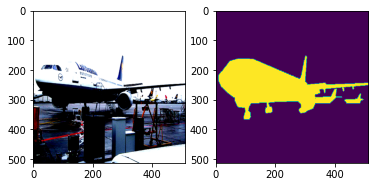

torch.Size([513, 513])

In [5]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1



sample = val_dataset.__getitem__(0)
image, mask = sample[0], sample[1]
print(type(image))
print(image.size())
image.transpose_(0, 2)
image.transpose_(0, 1)
print(image.size())

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)    #.transpose(0,1)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()
mask.size()


In [11]:
# collate_fn
"""
def cat_list(images, fill_value=0):
    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    batch_shape = (len(images),) + max_size
    batched_imgs = images[0].new(*batch_shape).fill_(fill_value)
    for img, pad_img in zip(images, batched_imgs):
        pad_img[..., :img.shape[-2], :img.shape[-1]].copy_(img)
    return batched_imgs

def my_collate(batch):
    images, targets = list(zip(*batch))
    batched_imgs = cat_list(images, fill_value=0)
    batched_targets = cat_list(targets, fill_value=255)
    return batched_imgs, batched_targets
"""
def my_collate(batch):
    print(batch[0][0].size())
    data = [item[0] for item in batch]  # just form a list of tensor

    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]
# Set batch_size
batch_size = 4

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)#,shuffle=True,collate_fn=my_collate,drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)#,collate_fn=my_collate,drop_last=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)



device : cuda:0


In [12]:
print("Taille dataset train :",len(train_dataset))
print("Taille dataset val :",len(val_dataset))

Taille dataset train : 1464
Taille dataset val : 1449


## Metric code

In [13]:
SMOOTH = 1e-6
def iou(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    #iou_metric = ((iou-0.5)*2*10).floor()/10
    #iou_metric[iou_metric<0] = 0

    return iou.mean()  # Or thresholded.mean() if you are interested in average across the batch
    


 
iou(next(iter(dataloader_val))[1],next(iter(dataloader_train))[1])

tensor(0.0564)

In [14]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) + label_pred[mask],
        minlength=n_class ** 2,
    ).reshape(n_class, n_class)
    return hist


def scores(label_trues, label_preds, n_class=21):
    label_trues = label_trues.cpu().numpy()
    label_preds = label_preds.cpu().numpy()
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    valid = hist.sum(axis=1) > 0  # added
    mean_iu = np.nanmean(iu[valid])
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    cls_iu = dict(zip(range(n_class), iu))

    return {
        "Pixel Accuracy": acc,
        "Mean Accuracy": acc_cls,
        "Frequency Weighted IoU": fwavacc,
        "Mean IoU": mean_iu,
        "Class IoU": cls_iu,
    }

In [15]:
def evaluate_model(model,val_loader,criterion=nn.CrossEntropyLoss(ignore_index=21),nclass=21):
  loss_test = []
  iou_test = []
  pixel_accuracy = []
  weight_iou = []
  with torch.no_grad():
    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)

          model.eval()
          pred = model(x)


          loss = criterion(pred,mask)
          loss_test.append(loss.item())
          
          s = scores(pred.max(dim=1)[1],mask)
          ioU = float(iou(pred.argmax(dim=1),mask))
          """
            return {
              "Pixel Accuracy": acc,
              "Mean Accuracy": acc_cls,
              "Frequency Weighted IoU": fwavacc,
              "Mean IoU": mean_iu,
              "Class IoU": cls_iu,
          }
          """
          iou_test.append(ioU)
          pixel_accuracy.append(s["Pixel Accuracy"])
          weight_iou.append(s["Frequency Weighted IoU"])

    

    print("Mean IOU :",np.array(iou_test).mean(),"Frequency Weighted IOU :",np.array(weight_iou).mean(),\
          "Pixel Accuracy :",np.array(pixel_accuracy).mean(),"Loss Validation :",np.array(loss_test).mean())


## DeepLabV3 Pytorch

In [16]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Training

In [17]:
learning_rate = 0.02
moment = 0.9
wd = 1e-4
n_epochs = 175
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=moment, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: (1 - x / (len(dataloader_train) * n_epochs)) ** 0.9)

#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

In [18]:
SAVE_DIR = '/data/model'
save = os.path.join(SAVE_DIR,'deeplabv3_voc.pt')
iou_train = []
loss_train = []
iou_test = []
loss_test = []
all_loss_train = []
all_loss_test = []
all_iou = []

In [ ]:
for ep in range(n_epochs):
    print("EPOCH",ep)

    for i,(x,mask) in enumerate(dataloader_train):
          x = x.to(device)
          mask = mask.to(device)
          model.train()
          pred = model(x)
          pred = pred["out"]
          loss = criterion(pred,mask)
          all_loss_train.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          all_iou.append(float(iou(pred.argmax(dim=1).detach(),mask.detach())))
          optimizer.step()
          lr_scheduler.step()
          

    m_iou = np.array(all_iou).mean()
    m_loss = np.array(all_loss_train).mean()
    loss_train.append(m_loss)
    iou_train.append(m_iou)
    all_loss_train = []
    all_iou = []
    print("EP:",ep," loss train:",m_loss," iou train:",m_iou)
    
    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)
          model.eval()
          with torch.no_grad():
            pred = model(x)
            pred = pred["out"]
          loss = criterion(pred,mask)
          all_loss_test.append(loss.item())
          all_iou.append(float(iou(pred.argmax(dim=1).detach(),mask.detach())))
    
    m_iou = np.array(all_iou).mean()
    m_loss = np.array(all_loss_test).mean()
    loss_test.append(m_loss)
    iou_test.append(m_iou)
    all_loss_test = []
    all_iou = []
    print("EP:",ep," loss test:",m_loss," iou test:",m_iou)


    torch.save(model,save)
    

EPOCH 0


In [ ]:
import pickle
save = os.path.join(SAVE_DIR,'fcn32_bn_loss_train.pkl')
with open(save,'wb') as f:
    pickle.dump(loss_train,f)
save = os.path.join(SAVE_DIR,'fcn32_bn_loss_test.pkl')
with open(save,'wb') as f:
    pickle.dump(loss_test,f)
save = os.path.join(SAVE_DIR,'fcn32_bn_iou_train.pkl')
with open(save,'wb') as f:
    pickle.dump(iou_train,f)
save = os.path.join(SAVE_DIR,'fcn32_bn_iou_test.pkl')
with open(save,'wb') as f:
    pickle.dump(iou_test,f)

## Plot

In [ ]:
x,mask = next(iter(dataloader_val))
i = 3
x = x.to(device)
mask = mask.to(device)
pred = fcn32(x)
fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(pred.max(dim=1)[1][i].cpu())

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[i])

plt.show()

class_pred = []
class_mask = []

for p in pred.argmax(dim=1)[i].unique():
  class_pred.append(VOC_CLASSES[int(p)])
for m in mask[i].unique():
  class_mask.append(VOC_CLASSES[int(m)])

print("Classe prédite : ",class_pred)
print("Classe réelle : ",class_mask)
print(scores(pred.argmax(dim=1)[i],mask[i])["Pixel Accuracy"])
print("IOU sur ce masque :",float(iou(pred.argmax(dim=1)[i].unsqueeze(0),mask[i].unsqueeze(0))))


In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

## Implémentation de la variante FCN-16s 

In [ ]:
class FCN16_VGG16(torch.nn.Module): # Archi FCN-16s du papier
    def __init__(self,fcn32):
        super(FCN16_VGG16,self).__init__()
        
        self.features_pool4 = nn.Sequential(*list(fcn32.features_im_net.children())[:24]) # Features coupé à la couche pool4
        self.features_fc32 = nn.Sequential(*list(fcn32.features_im_net.children())[24:]) # Features complet de fc32
        # Classifieur FCN32
        self.conv1 = nn.Conv2d(512, 4096, 7,padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d()
        self.conv2 = nn.Conv2d(4096,4096,kernel_size=(1,1),padding=0)
        self.conv3 = nn.Conv2d(4096,21,kernel_size=(1,1),padding=0)
        
        # Copy Weight of FCN32
        self.conv1.weight = nn.Parameter(fcn32.conv1.weight)
        self.conv1.bias = fcn32.conv1.bias
        self.conv2.weight = nn.Parameter(fcn32.conv2.weight)
        self.conv2.bias = fcn32.conv2.bias
        self.conv3.weight = nn.Parameter(fcn32.conv3.weight)
        self.conv3.bias = fcn32.conv3.bias

        # Classifieur branche FCN16

        self.conv_fc16 = nn.Conv2d(512,21,kernel_size=(1,1)) # [14,14]
        

        # Upsampling
        self.final_upsampling = nn.UpsamplingBilinear2d(scale_factor=16)
        self.combine_classif_upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
        


    def forward(self,x):
        x = self.features_pool4(x)
        # branche fc32
        x1 = self.features_fc32(x)
        x1 = self.conv1(x1)
        x1 = self.relu1(x1)
        x1 = self.dropout(x1)
        x1 = self.conv2(x1)
        x1 = self.relu2(x1)
        x1 = self.dropout(x1)
        x1 = self.conv3(x1) # [7,7]
        x1 = self.combine_classif_upsampling(x1) # [14,14]
        
        # branche fc16
        x2 = self.conv_fc16(x)

        # Somme des classifieurs
        x = x1+x2 
        mask = self.final_upsampling(x)  

        return mask # [224,224]

In [ ]:
fcn16 = FCN16_VGG16(fcn32) # Comme l'article on réentraine sur fc32
fcn16.to(device)

### Training

In [ ]:
learning_rate = 10e-4
moment = 0.9
optimizer = torch.optim.SGD(fcn16.parameters(),lr=learning_rate,weight_decay=2e-4,momentum=moment)
n_epochs = 175
#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

In [ ]:
SAVE_DIR = '/data/model'
save = os.path.join(SAVE_DIR,'fcn16_bn.pt')
iou_train = []
loss_train = []
iou_test = []
loss_test = []
all_loss_train = []
all_loss_test = []
all_iou = []

In [ ]:
for ep in range(n_epochs):
    print("EPOCH",ep)

    for i,(x,mask) in enumerate(dataloader_train):
          x = x.to(device)
          mask = mask.to(device)
          fcn16.train()
          pred = fcn16(x)
          loss = criterion(pred,mask)
          all_loss_train.append(loss.item())
          loss.backward()
          all_iou.append(float(iou(pred.argmax(dim=1).detach(),mask.detach())))
          optimizer.step()
          optimizer.zero_grad()

    loss_train.append(np.array(all_loss_train).mean()) #.item() pour eviter fuite memoire
    iou_train.append(np.array(all_iou).mean())
    all_loss_train = []
    all_iou = []
    
    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)
          fcn16.eval()
          with torch.no_grad():
            pred = fcn16(x)
          loss = criterion(pred,mask)
          all_loss_test.append(loss.item())
          all_iou.append(float(iou(pred.argmax(dim=1).detach(),mask.detach())))
      
    loss_test.append(np.array(all_loss_test).mean())
    iou_test.append(np.array(all_iou).mean())
    all_loss_test = []
    all_iou = []

    if ep%20==0:
      try:
        i = 0
        fig = plt.figure()
        a = fig.add_subplot(1,2,1)
        plt.imshow(pred.argmax(dim=1)[i].detach().cpu().transpose_(0, 2).transpose_(0, 1))
        a = fig.add_subplot(1,2,2)
        plt.imshow(mask.cpu().detach().numpy()[i])
        plt.show()
        class_pred = []
        class_mask = []
        for p in pred.argmax(dim=1)[i].unique():
          class_pred.append(VOC_CLASSES[int(p)])
        for m in mask[i].unique():
          class_mask.append(VOC_CLASSES[int(m)])
        print("Classe prédite : ",class_pred)
        print("Classe réelle : ",class_mask)
      except:
        print('something with the plot image function')
    torch.save(fcn16,save)
    

In [ ]:
import pickle
save = os.path.join(SAVE_DIR,'fcn16_bn_loss_train.pkl')
with open(save,'wb') as f:
    pickle.dump(loss_train,f)
save = os.path.join(SAVE_DIR,'fcn16_bn_loss_test.pkl')
with open(save,'wb') as f:
    pickle.dump(loss_test,f)
save = os.path.join(SAVE_DIR,'fcn16_bn_iou_train.pkl')
with open(save,'wb') as f:
    pickle.dump(iou_train,f)
save = os.path.join(SAVE_DIR,'fcn16_bn_iou_test.pkl')
with open(save,'wb') as f:
    pickle.dump(iou_test,f)

### Plot

In [ ]:
x,mask = next(iter(dataloader_val))
i = 3
x = x.to(device)
mask = mask.to(device)
pred = fcn16(x)
fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(pred.max(dim=1)[1][i].cpu())

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[i])

plt.show()

class_pred = []
class_mask = []

for p in pred.argmax(dim=1)[i].unique():
  class_pred.append(VOC_CLASSES[int(p)])
for m in mask[i].unique():
  class_mask.append(VOC_CLASSES[int(m)])

print("Classe prédite : ",class_pred)
print("Classe réelle : ",class_mask)
print(scores(pred.argmax(dim=1)[i],mask[i])["Pixel Accuracy"])
print("IOU sur ce masque :",float(iou(pred.argmax(dim=1)[i].unsqueeze(0),mask[i].unsqueeze(0))))


In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 16s mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

In [ ]:
evaluate_model(fcn16,dataloader_val)

In [ ]:
fcn16 = torch.load('/data/model/fcn16.pt')

### Implémentation de la variante FCN-8s

In [ ]:
class FCN8_VGG16(torch.nn.Module): # Archi FCN-8s du papier
    def __init__(self,fcn16):
        super(FCN8_VGG16,self).__init__()
        self.features_pool3 = nn.Sequential(*list(fcn16.features_pool4.children())[:17]) # Features coupé à la couche pool3
        self.features_pool4 = nn.Sequential(*list(fcn16.features_pool4.children())[17:24]) # Features coupé à la couche pool4
        self.features_fc32 = nn.Sequential(*list(fcn16.features_fc32.children())) # Features complet de fc32
        # Classifieur FCN32
        self.conv1 = nn.Conv2d(512, 4096, 7, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        self.conv2 = nn.Conv2d(4096,4096,kernel_size=(1,1),padding=0)
        self.conv3 = nn.Conv2d(4096,21,kernel_size=(1,1),padding=0)

        # Copy weight from classifier
        self.conv1.weight = nn.Parameter(fcn16.conv1.weight)
        self.conv1.bias = fcn16.conv1.bias
        self.conv2.weight = nn.Parameter(fcn16.conv2.weight)
        self.conv2.bias = fcn16.conv2.bias
        self.conv3.weight = nn.Parameter(fcn16.conv3.weight)
        self.conv3.bias = fcn16.conv3.bias

        # Classifieur branche FCN16

        self.conv_fc16 = nn.Conv2d(512,21,kernel_size=(1,1)) # [14,14]

        # Classifieur branche FCN8

        self.conv_fc8 = nn.Conv2d(256,21,kernel_size=(1,1)) # [28,28]
        

        # Upsampling
        self.final_upsampling = nn.UpsamplingBilinear2d(scale_factor=8)
        self.combine_classif_upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
        


    def forward(self,x):
        x0 = self.features_pool3(x)
        # branche fc32 et fc16
        x1 = self.features_pool4(x0)

        # branche fc32
        x2 = self.features_fc32(x1)
        x2 = self.conv1(x2)
        x2 = self.relu1(x2)
        x2 = self.dropout(x2)
        x2 = self.conv2(x2)
        x2 = self.relu2(x2)
        x2 = self.dropout(x2)
        x2 = self.conv3(x2) # [7,7]
        x2 = self.combine_classif_upsampling(x2) # [14,14]
        
        # branche fc16
        x3 = self.conv_fc16(x1) # [14,14]

        # branche fc8
        x4 = self.conv_fc8(x0) # [28,28]

        # Somme des classifieurs fc16 et fc32
        x5 = x2+x3 # [14,14]
        x5 = self.combine_classif_upsampling(x5) # [28,28]

        # somme des classifieurs fc8 et fc16+32
        x6 = x5 + x4

        mask = self.final_upsampling(x6)  

        return mask # [224,224]

In [ ]:
fcn8 = FCN8_VGG16(fcn16) # Comme l'article on réentraine sur fc16
fcn8.to(device)

In [ ]:
batch_test = next(iter(dataloader_train))[0]
output_f = fcn8(batch_test.to(device))




fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(np.transpose(batch_test[0].cpu()))

a = fig.add_subplot(1,2,2)
plt.imshow(output_f[0][0].cpu().detach().numpy())

plt.show()

### Training

In [ ]:
learning_rate = 10e-4
moment = 0.9
optimizer = torch.optim.SGD(fcn8.parameters(),lr=learning_rate,weight_decay=5e-4,momentum=moment)
n_epochs = 175
#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

In [ ]:
SAVE_DIR = '/data/model'
save = os.path.join(SAVE_DIR,'fcn8_bn.pt')
iou_train = []
loss_train = []
iou_test = []
loss_test = []
all_loss_train = []
all_loss_test = []
all_iou = []

In [ ]:
for ep in range(n_epochs):
    print("EPOCH",ep)

    for i,(x,mask) in enumerate(dataloader_train):
          x = x.to(device)
          mask = mask.to(device)
          fcn8.train()
          pred = fcn8(x)
          loss = criterion(pred,mask)
          all_loss_train.append(loss.item())
          loss.backward()
          all_iou.append(float(iou(pred.argmax(dim=1).detach(),mask.detach())))
          optimizer.step()
          optimizer.zero_grad()

    loss_train.append(np.array(all_loss_train).mean()) #.item() pour eviter fuite memoire
    iou_train.append(np.array(all_iou).mean())
    all_loss_train = []
    all_iou = []
    
    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)
          fcn8.eval()
          with torch.no_grad():
            pred = fcn8(x)
          loss = criterion(pred,mask)
          all_loss_test.append(loss.item())
          all_iou.append(float(iou(pred.argmax(dim=1).detach(),mask.detach())))
      
    loss_test.append(np.array(all_loss_test).mean())
    iou_test.append(np.array(all_iou).mean())
    all_loss_test = []
    all_iou = []

    if ep%20==0:
      try:
        i = 0
        fig = plt.figure()
        a = fig.add_subplot(1,2,1)
        plt.imshow(pred.argmax(dim=1)[i].detach().cpu().transpose_(0, 2).transpose_(0, 1))
        a = fig.add_subplot(1,2,2)
        plt.imshow(mask.cpu().detach().numpy()[i])
        plt.show()
        class_pred = []
        class_mask = []
        for p in pred.argmax(dim=1)[i].unique():
          class_pred.append(VOC_CLASSES[int(p)])
        for m in mask[i].unique():
          class_mask.append(VOC_CLASSES[int(m)])
        print("Classe prédite : ",class_pred)
        print("Classe réelle : ",class_mask)
      except:
        print('something with the plot image function')
    torch.save(fcn8,save)
    

In [ ]:
import pickle
save = os.path.join(SAVE_DIR,'fcn8_bn_loss_train.pkl')
with open(save,'wb') as f:
    pickle.dump(loss_train,f)
save = os.path.join(SAVE_DIR,'fcn8_bn_loss_test.pkl')
with open(save,'wb') as f:
    pickle.dump(loss_test,f)
save = os.path.join(SAVE_DIR,'fcn8_bn_iou_train.pkl')
with open(save,'wb') as f:
    pickle.dump(iou_train,f)
save = os.path.join(SAVE_DIR,'fcn8_bn_iou_test.pkl')
with open(save,'wb') as f:
    pickle.dump(iou_test,f)

In [ ]:
fcn8=torch.load('/data/model/fcn8.pt')

### Plot 

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 8s mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

In [ ]:
evaluate_model(fcn8,dataloader_val)

In [ ]:
x,mask = next(iter(dataloader_val))
i = 2
device="cpu"
x = x.to(device)
mask = mask.to(device)
mask = mask[i]
fcn8.to(device)
pred = fcn8(x[i].unsqueeze(0))
fig = plt.figure()

plt.imshow(x[i].transpose_(0, 2).transpose_(0, 1))


fig = plt.figure()


a = fig.add_subplot(1,2,1)
plt.imshow(pred.argmax(dim=1)[0].cpu())

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy())

plt.show()

class_pred = []
class_mask = []

for p in pred.argmax(dim=1).unique():
  class_pred.append(VOC_CLASSES[int(p)])
for m in mask.unique():
  class_mask.append(VOC_CLASSES[int(m)])

print("Classe prédite : ",class_pred)
print("Classe réelle : ",class_mask)
print("IOU sur ce masque :",float(iou(pred.argmax(dim=1).unsqueeze(0),mask.unsqueeze(0))))
